
# 02 — Modelling (Feature Engineering, Regression & Classification)

**Goals**
- Clean feature engineering for regression and classification.
- Robust pipelines with cross‑validation and a held‑out test set.
- Leakage‑free classification (rating features excluded from classification features).
- Version‑safe metrics and exported artifacts.


In [1]:

# ---------------------------------------------------------
# Setup
# ---------------------------------------------------------
import os, re, ast, json, warnings
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, f1_score, roc_auc_score, confusion_matrix)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier,
                              GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
np.random.seed(42)

FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)
REP_DIR = Path("../reports"); REP_DIR.mkdir(parents=True, exist_ok=True)

DATA_CSV_CANDIDATES = ["../data/raw/zomato_df_final_data.csv",
                       "data/raw/zomato_df_final_data.csv",
                       "/mnt/data/zomato_df_final_data.csv"]

def existing(paths):
    for p in paths:
        if Path(p).exists():
            return p
    raise FileNotFoundError(paths)

def parse_listish(x):
    if pd.isna(x): return []
    if isinstance(x, list): return [str(t).strip() for t in x if str(t).strip()]
    s = str(x).strip()
    try:
        v = ast.literal_eval(s)
        if isinstance(v, (list, tuple)):
            return [str(t).strip() for t in v if str(t).strip()]
    except Exception:
        pass
    return [t.strip() for t in re.split(r",\s*", s) if t.strip()]


## 1) Load & feature engineering

In [2]:

csv_path = existing(DATA_CSV_CANDIDATES)
df = pd.read_csv(csv_path).drop_duplicates().copy()

# Light text normalization
for c in df.select_dtypes(include="object"):
    df[c] = df[c].astype(str).str.strip()

# Targets
df["cost_final"] = df["cost"].fillna(df["cost_2"])

# Parse multi-valued fields
df["cuisine_list"] = df["cuisine"].apply(parse_listish)
df["type_list"]    = df["type"].apply(parse_listish)
df["type_primary"] = df["type_list"].apply(lambda L: L[0] if L else np.nan)

# Cuisine multi-hot (top 15)
top_cuis = (pd.Series([c for L in df["cuisine_list"] for c in L])
            .value_counts().head(15).index.tolist())
for c in top_cuis:
    df[f"cuisine__{c}"] = df["cuisine_list"].apply(lambda L: int(isinstance(L, list) and c.lower() in [t.lower() for t in L]))

# Numeric cleanup
df["votes"] = pd.to_numeric(df["votes"], errors="coerce")
df["rating_number"] = pd.to_numeric(df["rating_number"], errors="coerce")

# Rows needed for modelling
df_model = df.dropna(subset=["votes", "rating_number", "cost_final"]).copy()
df_model["high_rating"] = (df_model["rating_number"] >= 4.0).astype(int)

# Regression features include rating_number; classification features exclude it (avoid leakage)
reg_feats = ["votes", "rating_number", "type_primary", "subzone"] + [c for c in df_model.columns if c.startswith("cuisine__")]
clf_feats = ["votes", "type_primary", "subzone"] + [c for c in df_model.columns if c.startswith("cuisine__")]

X_reg = df_model[reg_feats].copy(); y_reg = df_model["cost_final"].astype(float)
X_clf = df_model[clf_feats].copy(); y_clf = df_model["high_rating"].astype(int)

print("Shapes — X_reg:", X_reg.shape, "| X_clf:", X_clf.shape)
print("Class balance:", y_clf.value_counts(normalize=True).round(3).to_dict())


Shapes — X_reg: (7080, 19) | X_clf: (7080, 18)
Class balance: {0: 0.921, 1: 0.079}


## 2) Preprocessing pipelines

In [3]:

num_features_reg = ["votes", "rating_number"]
num_features_clf = ["votes"]

bin_features_reg = [c for c in X_reg.columns if c.startswith("cuisine__")]
bin_features_clf = [c for c in X_clf.columns if c.startswith("cuisine__")]

cat_nominal_reg  = ["type_primary", "subzone"]
cat_nominal_clf  = ["type_primary", "subzone"]

preprocess_reg = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_features_reg),
    ("bin", "passthrough", bin_features_reg),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_nominal_reg),
])

preprocess_clf = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_features_clf),
    ("bin", "passthrough", bin_features_clf),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_nominal_clf),
])


## 3) Train/Test split

In [4]:

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)


## 4) Cross‑validation — Regression

In [5]:

reg_models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
reg_results = []

for name, est in reg_models.items():
    pipe = Pipeline([("prep", preprocess_reg), ("model", est)])
    rmse = -cross_val_score(pipe, X_train_reg, y_train_reg, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    mae  = -cross_val_score(pipe, X_train_reg, y_train_reg, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)
    reg_results.append({"model": name, "cv_rmse_mean": rmse.mean(), "cv_rmse_std": rmse.std(),
                        "cv_mae_mean": mae.mean(), "cv_mae_std": mae.std()})
reg_table = pd.DataFrame(reg_results).sort_values("cv_rmse_mean")
display(reg_table)
reg_table.to_csv(REP_DIR / "regression_cv_results.csv", index=False)
print("saved:", REP_DIR / "regression_cv_results.csv")


,model,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_mae_std
2,GradientBoosting,20.343600,1.083588,14.349001,0.459734
0,LinearRegression,20.533385,0.651936,14.878792,0.299953
1,RandomForest,20.966278,0.827404,14.675936,0.445140


saved: ..\reports\regression_cv_results.csv


## 5) Test metrics — Regression (version‑safe)

In [6]:

best_reg_name = reg_table.iloc[0]["model"]
best_reg = reg_models[best_reg_name]

pipe_reg = Pipeline([("prep", preprocess_reg), ("model", best_reg)]).fit(X_train_reg, y_train_reg)
pred = pipe_reg.predict(X_test_reg)

# version‑safe RMSE
mse  = mean_squared_error(y_test_reg, pred)
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(y_test_reg, pred)
r2   = r2_score(y_test_reg, pred)

test_row = pd.DataFrame([{"model": best_reg_name, "test_rmse": rmse, "test_mae": mae, "test_r2": r2}])
display(test_row)
test_row.to_csv(REP_DIR / "regression_test_results.csv", index=False)
print("saved:", REP_DIR / "regression_test_results.csv")


,model,test_rmse,test_mae,test_r2
0,GradientBoosting,21.495519,14.632224,0.523481


saved: ..\reports\regression_test_results.csv


## 6) Cross‑validation — Classification (no leakage)

In [7]:

clf_models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

cv_cls = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_results = []
for name, est in clf_models.items():
    pipe = Pipeline([("prep", preprocess_clf), ("model", est)])
    acc = cross_val_score(pipe, X_train_clf, y_train_clf, scoring="accuracy", cv=cv_cls, n_jobs=-1)
    f1  = cross_val_score(pipe, X_train_clf, y_train_clf, scoring="f1", cv=cv_cls, n_jobs=-1)
    clf_results.append({"model": name, "cv_acc_mean": acc.mean(), "cv_acc_std": acc.std(),
                        "cv_f1_mean": f1.mean(), "cv_f1_std": f1.std()})
clf_table = pd.DataFrame(clf_results).sort_values("cv_f1_mean", ascending=False)
display(clf_table)
clf_table.to_csv(REP_DIR / "classification_cv_results.csv", index=False)
print("saved:", REP_DIR / "classification_cv_results.csv")


,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std
0,LogisticRegression,0.948269,0.003339,0.585507,0.038458
2,GradientBoosting,0.943856,0.004587,0.572437,0.033234
1,RandomForest,0.940148,0.004888,0.541796,0.043251


saved: ..\reports\classification_cv_results.csv


## 7) Test metrics — Classification

,model,test_acc,test_f1,test_auc
0,LogisticRegression,0.943503,0.512195,0.948473


saved: ..\reports\classification_test_results.csv


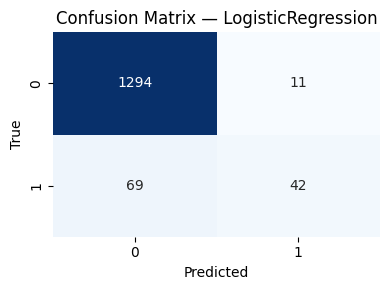

In [8]:

best_clf_name = clf_table.iloc[0]["model"]
best_clf = clf_models[best_clf_name]

pipe_clf = Pipeline([("prep", preprocess_clf), ("model", best_clf)]).fit(X_train_clf, y_train_clf)
pred  = pipe_clf.predict(X_test_clf)
proba = pipe_clf.predict_proba(X_test_clf)[:,1] if hasattr(pipe_clf, "predict_proba") else None

acc = accuracy_score(y_test_clf, pred)
f1  = f1_score(y_test_clf, pred)
auc = roc_auc_score(y_test_clf, proba) if proba is not None else np.nan

test_cls = pd.DataFrame([{"model": best_clf_name, "test_acc": acc, "test_f1": f1, "test_auc": auc}])
display(test_cls)
test_cls.to_csv(REP_DIR / "classification_test_results.csv", index=False)
print("saved:", REP_DIR / "classification_test_results.csv")

cm = confusion_matrix(y_test_clf, pred)
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(f"Confusion Matrix — {best_clf_name}")
plt.tight_layout(); plt.savefig(FIG_DIR / "classification_confusion_matrix.png", dpi=300, bbox_inches="tight"); plt.show()


## 8) Permutation importance & exports

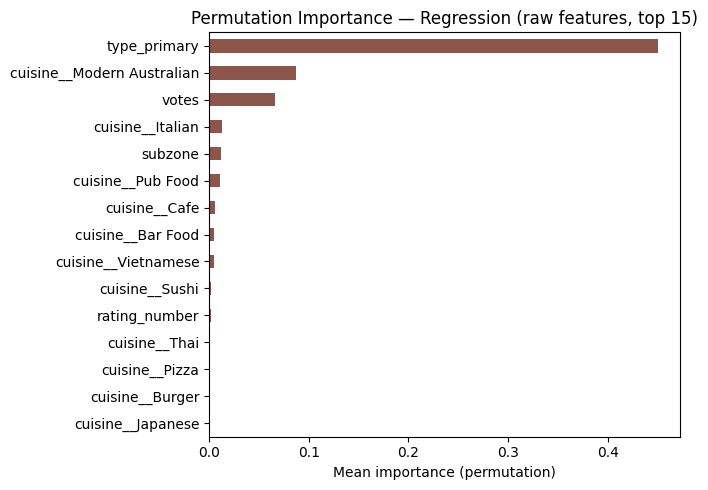

saved: ..\reports\regression_feature_importance_full.csv
saved: ..\reports\regression_feature_importance.csv


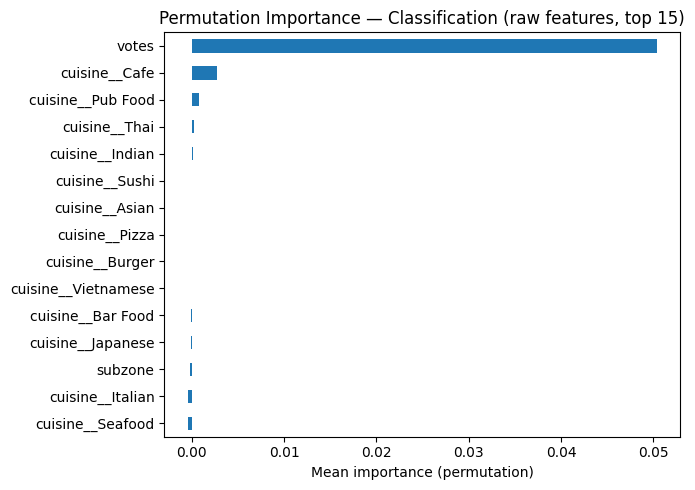

saved: ..\reports\classification_feature_importance_full.csv
saved: ..\reports\classification_feature_importance.csv


In [9]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _safe_feature_names(X, prefix="feat"):
    """Return raw feature names for X (DataFrame or ndarray)."""
    if hasattr(X, "columns"):
        return list(X.columns)
    import numpy as np
    return [f"{prefix}_{i}" for i in range(X.shape[1])]

def _plot_top(series, title, out_png, color="#1f77b4", topn=15):
    top = series.sort_values(ascending=False).head(topn)
    ax = top[::-1].plot(kind="barh", figsize=(7,5), color=color)
    ax.set_title(title)
    ax.set_xlabel("Mean importance (permutation)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    return top

# ---------- REGRESSION ----------
pipe_reg.fit(X_train_reg, y_train_reg)

fi_reg = permutation_importance(
    pipe_reg, X_test_reg, y_test_reg,
    n_repeats=10, random_state=42, n_jobs=-1
)

reg_raw_names = _safe_feature_names(X_test_reg, prefix="reg_feat")
reg_imp = pd.Series(fi_reg.importances_mean, index=reg_raw_names)

top_reg = _plot_top(
    reg_imp,
    title="Permutation Importance — Regression (raw features, top 15)",
    out_png=FIG_DIR / "regression_permutation_importance.png",
    color="#8c564b",
    topn=15
)

# Save full table (all features) and a top-15 convenience file
reg_imp.rename("importance").to_csv(REP_DIR / "regression_feature_importance_full.csv", index=True)
top_reg.rename("importance").to_csv(REP_DIR / "regression_feature_importance.csv", index=True)
print("saved:", REP_DIR / "regression_feature_importance_full.csv")
print("saved:", REP_DIR / "regression_feature_importance.csv")

# ---------- CLASSIFICATION ----------
pipe_clf.fit(X_train_clf, y_train_clf)

fi_clf = permutation_importance(
    pipe_clf, X_test_clf, y_test_clf,
    n_repeats=10, random_state=42, n_jobs=-1
)

clf_raw_names = _safe_feature_names(X_test_clf, prefix="clf_feat")
clf_imp = pd.Series(fi_clf.importances_mean, index=clf_raw_names)

top_clf = _plot_top(
    clf_imp,
    title="Permutation Importance — Classification (raw features, top 15)",
    out_png=FIG_DIR / "classification_permutation_importance.png",
    color="#1f77b4",
    topn=15
)

clf_imp.rename("importance").to_csv(REP_DIR / "classification_feature_importance_full.csv", index=True)
top_clf.rename("importance").to_csv(REP_DIR / "classification_feature_importance.csv", index=True)
print("saved:", REP_DIR / "classification_feature_importance_full.csv")
print("saved:", REP_DIR / "classification_feature_importance.csv")


## 9) Model cards

In [10]:

summary = {
    "regression": {"best_model": reg_table.iloc[0]["model"],
                   **pd.read_csv(REP_DIR / "regression_test_results.csv").iloc[0].to_dict()},
    "classification": {"best_model": clf_table.iloc[0]["model"],
                        **pd.read_csv(REP_DIR / "classification_test_results.csv").iloc[0].to_dict()},
    "n_samples": int(len(df_model)),
    "n_features_reg": int(X_reg.shape[1]),
    "n_features_clf": int(X_clf.shape[1]),
    "top_cuisines_engineered": list(top_cuis)
}
with open(REP_DIR / "model_cards.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print("saved:", REP_DIR / "model_cards.json"); summary


saved: ..\reports\model_cards.json


{'regression': {'best_model': 'GradientBoosting',
  'model': 'GradientBoosting',
  'test_rmse': 21.495518912111997,
  'test_mae': 14.632223982158756,
  'test_r2': 0.5234807898345275},
 'classification': {'best_model': 'LogisticRegression',
  'model': 'LogisticRegression',
  'test_acc': 0.943502824858757,
  'test_f1': 0.5121951219512195,
  'test_auc': 0.948472610541576},
 'n_samples': 7080,
 'n_features_reg': 19,
 'n_features_clf': 18,
 'top_cuisines_engineered': ['Cafe',
  'Modern Australian',
  'Chinese',
  'Italian',
  'Pizza',
  'Thai',
  'Japanese',
  'Asian',
  'Burger',
  'Indian',
  'Seafood',
  'Vietnamese',
  'Sushi',
  'Pub Food',
  'Bar Food']}